In [0]:
spark

In [0]:
!pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/82.7 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/78.2 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 7.6 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=369d27e37cf04070e4065a1a9d5d972545f90b407403fcfa89c1229cc512730a
  Stored in directory: /root/.cache/pip/wheels/46/d2/26/84d0a1acdb9c6baccf7d28cf06962ec80529fe1ad938489983
Successfully built kaggle
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import os
import json

# Load kaggle.json (assuming it’s in the '/dbfs/tmp/' directory)
with open('/Workspace/Users/jkope@gmu.edu/kaggle.json', 'r') as f: # replace with your own path
    kaggle_credentials = json.load(f)

# Set the environment variables for authentication
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

# Check if credentials are set correctly
print("Kaggle credentials are set")

Kaggle credentials are set


In [0]:
!kaggle datasets download -d matt2434/cleaned-ecommerce-data -p /dbfs/tmp/kaggle_data && unzip /dbfs/tmp/kaggle_data/cleaned-ecommerce-data.zip -d /dbfs/tmp/kaggle_data

Dataset URL: https://www.kaggle.com/datasets/matt2434/cleaned-ecommerce-data
License(s): apache-2.0
100%|███████████████████████████████████████| 1.65G/1.65G [00:18<00:00, 152MB/s]
100%|██████████████████████████████████████| 1.65G/1.65G [00:18<00:00, 94.4MB/s]
Archive:  /dbfs/tmp/kaggle_data/cleaned-ecommerce-data.zip
  inflating: /dbfs/tmp/kaggle_data/2019-Dec-Cleaned.csv  
  inflating: /dbfs/tmp/kaggle_data/2019-Nov-Cleaned.csv  


In [0]:
dbutils.fs.ls("dbfs:/tmp/kaggle_data")

[FileInfo(path='dbfs:/tmp/kaggle_data/2019-Dec-Cleaned.csv', name='2019-Dec-Cleaned.csv', size=395749939, modificationTime=1732684596000),
 FileInfo(path='dbfs:/tmp/kaggle_data/2019-Nov-Cleaned.csv', name='2019-Nov-Cleaned.csv', size=5981645247, modificationTime=1732684662000),
 FileInfo(path='dbfs:/tmp/kaggle_data/cleaned-ecommerce-data.zip', name='cleaned-ecommerce-data.zip', size=1776673282, modificationTime=1732684590000)]

In [0]:
nov_path = 'dbfs:/tmp/kaggle_data/2019-Nov-Cleaned.csv'
dec_path = 'dbfs:/tmp/kaggle_data/2019-Dec-Cleaned.csv'

novf = spark.read.csv(nov_path, header=True, inferSchema=True)
decf = spark.read.csv(dec_path, header=True, inferSchema=True)

In [0]:
novf.show()

+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|  brand| price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+
|2019-11-01 00:00:00|      view|   1003461|2053013555631882655|electronics.smart...| xiaomi|489.07|520088904|4d3b30da-a5e4-49d...|
|2019-11-01 00:00:00|      view|   5000088|2053013566100866035|appliances.sewing...| janome|293.65|530496790|8e5f4f83-366c-4f7...|
|2019-11-01 00:00:01|      view|   3601530|2053013563810775923|appliances.kitche...|     lg|712.87|518085591|3bfb58cd-7892-48c...|
|2019-11-01 00:00:01|      view|   1004775|2053013555631882655|electronics.smart...| xiaomi|183.27|558856683|313628f1-68b8-460...|
|2019-11-01 00:00:01|      view|   1306894|2053013558920217191|  computers.notebook

In [0]:
df = novf.union(decf)

In [0]:
# Step 0: Import Libraries for Preprocessing Brand
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [0]:
# Step 1: Use StringIndexer to convert brand column to numeric indices
indexer = StringIndexer(inputCol="brand", outputCol="brand_index")
df_indexed = indexer.fit(df).transform(df)
df_indexed.show(truncate=False)

+-------------------+----------+----------+-------------------+-----------------------------------+-------+------+---------+------------------------------------+-----------+
|event_time         |event_type|product_id|category_id        |category_code                      |brand  |price |user_id  |user_session                        |brand_index|
+-------------------+----------+----------+-------------------+-----------------------------------+-------+------+---------+------------------------------------+-----------+
|2019-11-01 00:00:00|view      |1003461   |2053013555631882655|electronics.smartphone             |xiaomi |489.07|520088904|4d3b30da-a5e4-49df-b1a8-ba5943f1dd33|2.0        |
|2019-11-01 00:00:00|view      |5000088   |2053013566100866035|appliances.sewing_machine          |janome |293.65|530496790|8e5f4f83-366c-4f70-860e-ca7417414283|31.0       |
|2019-11-01 00:00:01|view      |3601530   |2053013563810775923|appliances.kitchen.washer          |lg     |712.87|518085591|3bfb58

In [0]:
# Step 2: Fit the OneHotEncoder on the indexed column
encoder = OneHotEncoder(inputCol="brand_index", outputCol="brand_onehot")
encoder_model = encoder.fit(df_indexed)  # Fit the encoder
df_encoded = encoder_model.transform(df_indexed)  # Transform the data using the fitted model

df_encoded.show(truncate=False)

+-------------------+----------+----------+-------------------+-----------------------------------+-------+------+---------+------------------------------------+-----------+------------------+
|event_time         |event_type|product_id|category_id        |category_code                      |brand  |price |user_id  |user_session                        |brand_index|brand_onehot      |
+-------------------+----------+----------+-------------------+-----------------------------------+-------+------+---------+------------------------------------+-----------+------------------+
|2019-11-01 00:00:00|view      |1003461   |2053013555631882655|electronics.smartphone             |xiaomi |489.07|520088904|4d3b30da-a5e4-49df-b1a8-ba5943f1dd33|2.0        |(3514,[2],[1.0])  |
|2019-11-01 00:00:00|view      |5000088   |2053013566100866035|appliances.sewing_machine          |janome |293.65|530496790|8e5f4f83-366c-4f70-860e-ca7417414283|31.0       |(3514,[31],[1.0]) |
|2019-11-01 00:00:01|view      |360

In [0]:
# Removing Outliers from Price
from pyspark.sql import functions as F

# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile)
q1 = df_encoded.approxQuantile("price", [0.25], 0.01)[0]  # 25th percentile
q3 = df_encoded.approxQuantile("price", [0.75], 0.01)[0]  # 75th percentile

# Step 2: Calculate IQR (Interquartile Range)
iqr = q3 - q1

# Step 3: Define outlier bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Step 4: Filter out outliers
df_filtered = df_encoded.filter((df_encoded["price"] >= lower_bound) & (df_encoded["price"] <= upper_bound))

df_filtered.show(truncate=False)


+-------------------+----------+----------+-------------------+-----------------------------------+-------+------+---------+------------------------------------+-----------+------------------+
|event_time         |event_type|product_id|category_id        |category_code                      |brand  |price |user_id  |user_session                        |brand_index|brand_onehot      |
+-------------------+----------+----------+-------------------+-----------------------------------+-------+------+---------+------------------------------------+-----------+------------------+
|2019-11-01 00:00:00|view      |1003461   |2053013555631882655|electronics.smartphone             |xiaomi |489.07|520088904|4d3b30da-a5e4-49df-b1a8-ba5943f1dd33|2.0        |(3514,[2],[1.0])  |
|2019-11-01 00:00:00|view      |5000088   |2053013566100866035|appliances.sewing_machine          |janome |293.65|530496790|8e5f4f83-366c-4f70-860e-ca7417414283|31.0       |(3514,[31],[1.0]) |
|2019-11-01 00:00:01|view      |360

In [0]:
#3. Preprocess the Data (Ensure the data is cleaned and in the correct format (numerical values only)).
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['price', 'brand_index'],
    outputCol='features'
)

feature_df = assembler.transform(df_filtered)

In [0]:
# 4. Import and Train K-means Model
from pyspark.ml.clustering import KMeans

# Set the number of clusters (k)
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(feature_df)


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
# 5. Evaluate the Model
# Make predictions
predictions = model.transform(feature_df)
predictions.show()

# Evaluate clustering by computing Within Set Sum of Squared Errors (WSSSE)
wssse = model.summary.trainingCost
print("Within Set Sum of Squared Errors = " + str(wssse))


+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+-----------+------------------+-------------+----------+
|         event_time|event_type|product_id|        category_id|       category_code|  brand| price|  user_id|        user_session|brand_index|      brand_onehot|     features|prediction|
+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+-----------+------------------+-------------+----------+
|2019-11-01 00:00:00|      view|   1003461|2053013555631882655|electronics.smart...| xiaomi|489.07|520088904|4d3b30da-a5e4-49d...|        2.0|  (3514,[2],[1.0])| [489.07,2.0]|         0|
|2019-11-01 00:00:00|      view|   5000088|2053013566100866035|appliances.sewing...| janome|293.65|530496790|8e5f4f83-366c-4f7...|       31.0| (3514,[31],[1.0])|[293.65,31.0]|         1|
|2019-11-01 00:00:01|      view|   3601530|2053013563810775923|ap

In [0]:
# 6. Anazlyze the Clusters
# Display cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)


Cluster Centers: 
[674.13765494  18.51047531]
[170.06646369  43.78595293]
[145.39606236 778.14483276]


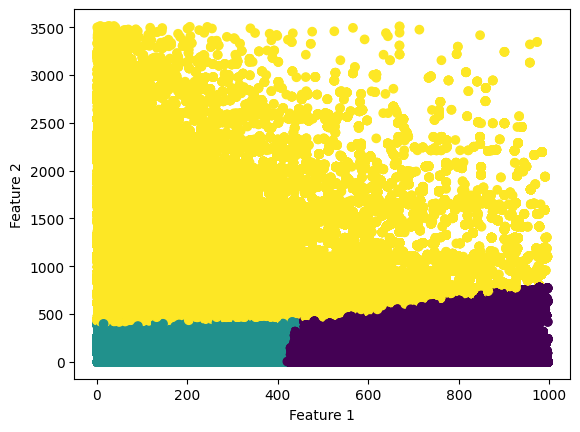

In [0]:
# 7. Visualize the Clusters
import matplotlib.pyplot as plt

pandas_df = predictions.select("price", "brand_index", "prediction").toPandas()

plt.scatter(pandas_df['price'], pandas_df['brand_index'], c=pandas_df['prediction'], cmap='viridis')
plt.xlabel('Feature 1') # Price
plt.ylabel('Feature 2') # Brand_Index
plt.show()
